In [1]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Socrata("data.lacity.org", None)
results = client.get("nxs9-385f", limit = 200000000) #population df
results_df = pd.DataFrame.from_records(results)
results_df.head()

,zip_code,total_population,median_age,total_males,total_females,total_households,average_household_size
0,91371,1,73.5,0,1,1,1.00
1,90001,57110,26.6,28468,28642,12971,4.40
2,90002,51223,25.5,24876,26347,11731,4.36
3,90003,66266,26.3,32631,33635,15642,4.22
4,90004,62180,34.8,31302,30878,22547,2.73


In [3]:
results_df['zip_code']=np.array(results_df['zip_code']).astype(int) 

In [4]:
la = pd.read_csv('safetyLA_Apr.csv',index_col=0)
la['crime_class'] = ''
la['weapon_class'] = ''
la['crime_level_score'] = ''
la['weapon_level_score'] = ''
la['danger_score'] = ''
la.head(5)

,Case_No,Days_of_Mon,Time_occured(24hr),Areas,Zip_Codes,Crimes,Weapons,crime_class,weapon_class,crime_level_score,weapon_level_score,danger_score
0,221008086,17,700,West Valley,91335.0,BATTERY - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",,,,,
1,221809363,18,830,Southeast,90059.0,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",UNKNOWN WEAPON/OTHER WEAPON,,,,,
2,220407651,15,1700,Hollenbeck,90031.0,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,NaN,,,,,
3,221809380,17,1900,Southeast,90002.0,BURGLARY,UNKNOWN WEAPON/OTHER WEAPON,,,,,
4,221108036,18,935,Northeast,90039.0,VEHICLE - STOLEN,NaN,,,,,


In [5]:
la['Zip_Codes']=np.array(la['Zip_Codes']).astype(int) #Convert zip codes doubles into int

In [6]:
la['pop']= np.zeros(len(la),dtype=int) #adding new column population
new_la = la

In [7]:
new_la.head()

,Case_No,Days_of_Mon,Time_occured(24hr),Areas,Zip_Codes,Crimes,Weapons,crime_class,weapon_class,crime_level_score,weapon_level_score,danger_score,pop
0,221008086,17,700,West Valley,91335,BATTERY - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",,,,,,0
1,221809363,18,830,Southeast,90059,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",UNKNOWN WEAPON/OTHER WEAPON,,,,,,0
2,220407651,15,1700,Hollenbeck,90031,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,NaN,,,,,,0
3,221809380,17,1900,Southeast,90002,BURGLARY,UNKNOWN WEAPON/OTHER WEAPON,,,,,,0
4,221108036,18,935,Northeast,90039,VEHICLE - STOLEN,NaN,,,,,,0


In [8]:
def add_pop(df_pop,df_zips):
    j = 0
    for zips in df_zips['Zip_Codes']:
        for i in range(len(df_pop)):
            if zips == df_pop['zip_code'][i]:
                df_zips['pop'][j] = df_pop['total_population'][i]
                break
        j = j + 1
    return(df_zips)

In [9]:
new_la = add_pop(results_df,new_la)
len(new_la[['Areas','Zip_Codes','pop']])

8214

In [10]:
len(new_la[['Areas','Zip_Codes','pop']].drop_duplicates(subset = ['Zip_Codes']))

124

In [11]:
zips_unique = new_la[['Areas','Zip_Codes','pop']].drop_duplicates(subset = ['Zip_Codes']) #filter with unique zip codes
zips_unique['pop'] = np.array(zips_unique['pop']).astype(int)

In [12]:
total_pop = zips_unique.groupby('Areas',as_index = False)['pop'].agg({'total_pop':sum})

In [39]:
len(list(la['Crimes'].unique()))

83

In [38]:
la['Crimes'].value_counts().head(30)

VEHICLE - STOLEN                                            1098
BATTERY - SIMPLE ASSAULT                                     748
THEFT OF IDENTITY                                            693
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT               533
BURGLARY                                                     515
BURGLARY FROM VEHICLE                                        510
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)      459
INTIMATE PARTNER - SIMPLE ASSAULT                            425
ROBBERY                                                      323
THEFT PLAIN - PETTY ($950 & UNDER)                           310
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              261
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)          252
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     206
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                     200
CRIMINAL THREATS - NO WEAPON DISPLAYED                       196
BRANDISH WEAPON          

In [14]:
weaponlist = list(la['Weapons'].dropna().unique())
firearm = ['HAND GUN',
           'UNKNOWN FIREARM',
           'SEMI-AUTOMATIC PISTOL',
           'AIR PISTOL/REVOLVER/RIFLE/BB GUN',
           'OTHER FIREARM',
           'BOMB THREAT',
           'FIRE',
           'ASSAULT WEAPON/UZI/AK47/ETC',
           'HECKLER & KOCH 93 SEMIAUTOMATIC ASSAULT RIFLE',
           'SAWED OFF RIFLE/SHOTGUN']

strongarm = ['STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)']
otherweapon = list(set(weaponlist) - set(strongarm) - set(firearm))


In [15]:
la['weapon_class'][la['Weapons'].isin(firearm)] = 'Firearm'
la['weapon_class'][la['Weapons'].isin(otherweapon)] = 'Non-gun Weapon'
la['weapon_class'][la['Weapons'].isin(strongarm)] = 'Strong Arm'
la['weapon_class'][la['Weapons'].isna()] = 'No Weapon'

In [16]:
crimelist = list(la['Crimes'].unique())
severe_crime = ['ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
                'INTIMATE PARTNER - AGGRAVATED ASSAULT',
                'INTIMATE PARTNER - AGGRAVATED ASSAULT',
                'BURGLARY','BURGLARY FROM VEHICLE',
                'BRANDISH WEAPON','CRIMINAL THREATS - NO WEAPON DISPLAYED',
                'RAPE, FORCIBLE','SHOTS FIRED AT INHABITED DWELLING','CRIMINAL HOMICIDE','ARSON',
                'INDECENT EXPOSURE','SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT',
                'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER','CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',
                'CHILD ANNOYING (17YRS & UNDER)','KIDNAPPING','LEWD/LASCIVIOUS ACTS WITH CHILD','']


light_crime = ['VIOLATION OF RESTRAINING ORDER',
         'VIOLATION OF COURT ORDER',
         'ATTEMPTED ROBBERY',
         'VEHICLE - ATTEMPT STOLEN',
         'DOCUMENT FORGERY / STOLEN FELONY','FAILURE TO YIELD',
         'CHILD NEGLECT (SEE 300 W.I.C.)','RESISTING ARREST','THROWING OBJECT AT MOVING VEHICLE',
         'RECKLESS DRIVING','ILLEGAL DUMPING','BRIBERY']

medium_crime = list(set(crimelist) - set(severe_crime) - set(light_crime))


In [17]:
la['crime_class'][la['Crimes'].isin(severe_crime)] = 'Severe Crime'
la['crime_class'][la['Crimes'].isin(medium_crime)] = 'Medium Crime'
la['crime_class'][la['Crimes'].isin(light_crime)] = 'Light Crime'
la.head()

,Case_No,Days_of_Mon,Time_occured(24hr),Areas,Zip_Codes,Crimes,Weapons,crime_class,weapon_class,crime_level_score,weapon_level_score,danger_score,pop
0,221008086,17,700,West Valley,91335,BATTERY - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Medium Crime,Strong Arm,,,,74363
1,221809363,18,830,Southeast,90059,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",UNKNOWN WEAPON/OTHER WEAPON,Severe Crime,Non-gun Weapon,,,,40952
2,220407651,15,1700,Hollenbeck,90031,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,NaN,Medium Crime,No Weapon,,,,39316
3,221809380,17,1900,Southeast,90002,BURGLARY,UNKNOWN WEAPON/OTHER WEAPON,Severe Crime,Non-gun Weapon,,,,51223
4,221108036,18,935,Northeast,90039,VEHICLE - STOLEN,NaN,Medium Crime,No Weapon,,,,28514


In [18]:
la.loc[la.crime_class == 'Severe Crime', 'crime_level_score'] = 0.6
la.loc[la.crime_class == 'Medium Crime', 'crime_level_score'] = 0.3
la.loc[la.crime_class == 'Light Crime', 'crime_level_score'] = 0.1

la.loc[la.weapon_class == 'Firearm', 'weapon_level_score'] = 0.4
la.loc[la.weapon_class == 'Non-gun Weapon', 'weapon_level_score'] = 0.3
la.loc[la.weapon_class == 'Strong Arm', 'weapon_level_score'] = 0.2
la.loc[la.weapon_class == 'No Weapon', 'weapon_level_score'] = 0.1

la['danger_score'] = la['crime_level_score'] * la['weapon_level_score']
la['danger_score'] = la['danger_score'].astype(float)

In [19]:
area_summary = la.groupby(['Areas','crime_class'])['crime_class'].count()
area_summary.to_csv('area_summary.csv')

plot_area = pd.read_csv('area_summary.csv',names = ['Area','Crime_class','Count'],skiprows = 1)
plot_area.head()

,Area,Crime_class,Count
0,77th Street,Light Crime,16
1,77th Street,Medium Crime,357
2,77th Street,Severe Crime,151
3,Central,Light Crime,22
4,Central,Medium Crime,450


In [20]:
plot_area.pivot_table('Count', ['Area'], 'Crime_class')

Crime_class,Light Crime,Medium Crime,Severe Crime
Area,,,
77th Street,16,357,151
Central,22,450,265
Devonshire,9,202,57
Foothill,6,177,69
Harbor,21,242,90
Hollenbeck,19,203,58
Hollywood,7,284,95
Mission,25,242,61
N Hollywood,4,238,93


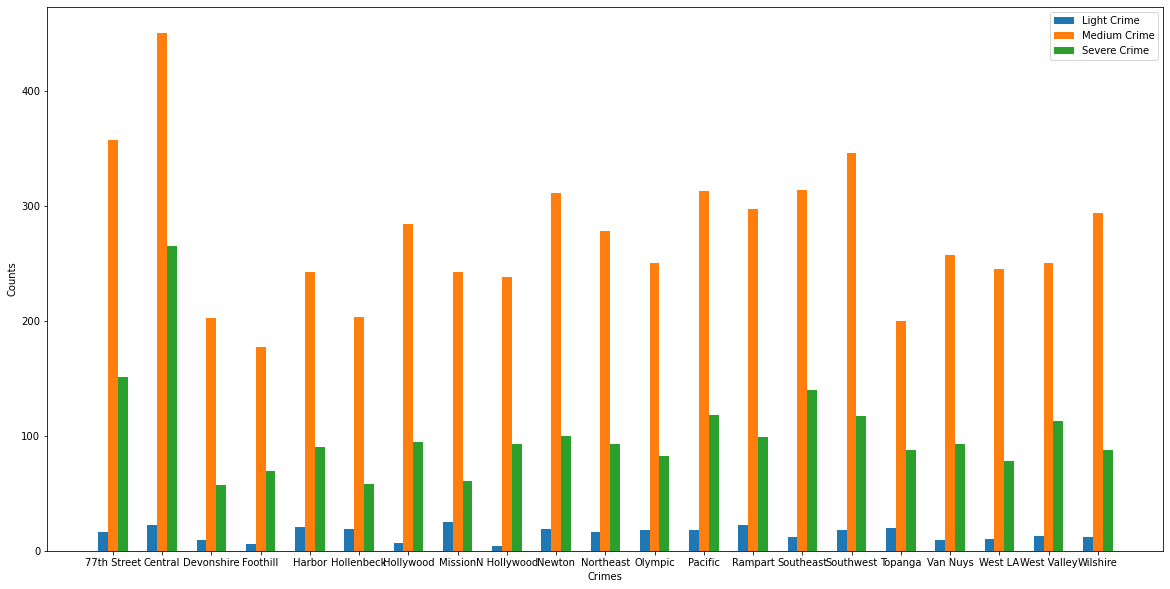

In [21]:
labels = list(plot_area['Area'].unique())
light_crime = list(plot_area['Count'][plot_area['Crime_class'] == 'Light Crime'])
medium_crime = list(plot_area['Count'][plot_area['Crime_class'] == 'Medium Crime'])
severe_crime = list(plot_area['Count'][plot_area['Crime_class'] == 'Severe Crime'])

x = np.arange(len(labels))  
width = 0.2

fig, ax = plt.subplots(figsize = [20,10])
ax.bar(x - width, light_crime, width, label='Light Crime')
ax.bar(x, medium_crime, width, label='Medium Crime')
ax.bar(x + width, severe_crime, width, label='Severe Crime')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_xlabel('Crimes')
plt.xticks(x,labels)
plt.legend()
plt.show()


In [22]:
weapon_summary = la.groupby(['Areas','weapon_class'])['weapon_class'].count()
weapon_summary.to_csv('weapon_summary.csv')

plot_weapon = pd.read_csv('weapon_summary.csv',names = ['Area','Weapon_class','Count'],skiprows = 1)
plot_weapon.head()

,Area,Weapon_class,Count
0,77th Street,Firearm,78
1,77th Street,No Weapon,268
2,77th Street,Non-gun Weapon,64
3,77th Street,Strong Arm,114
4,Central,Firearm,26


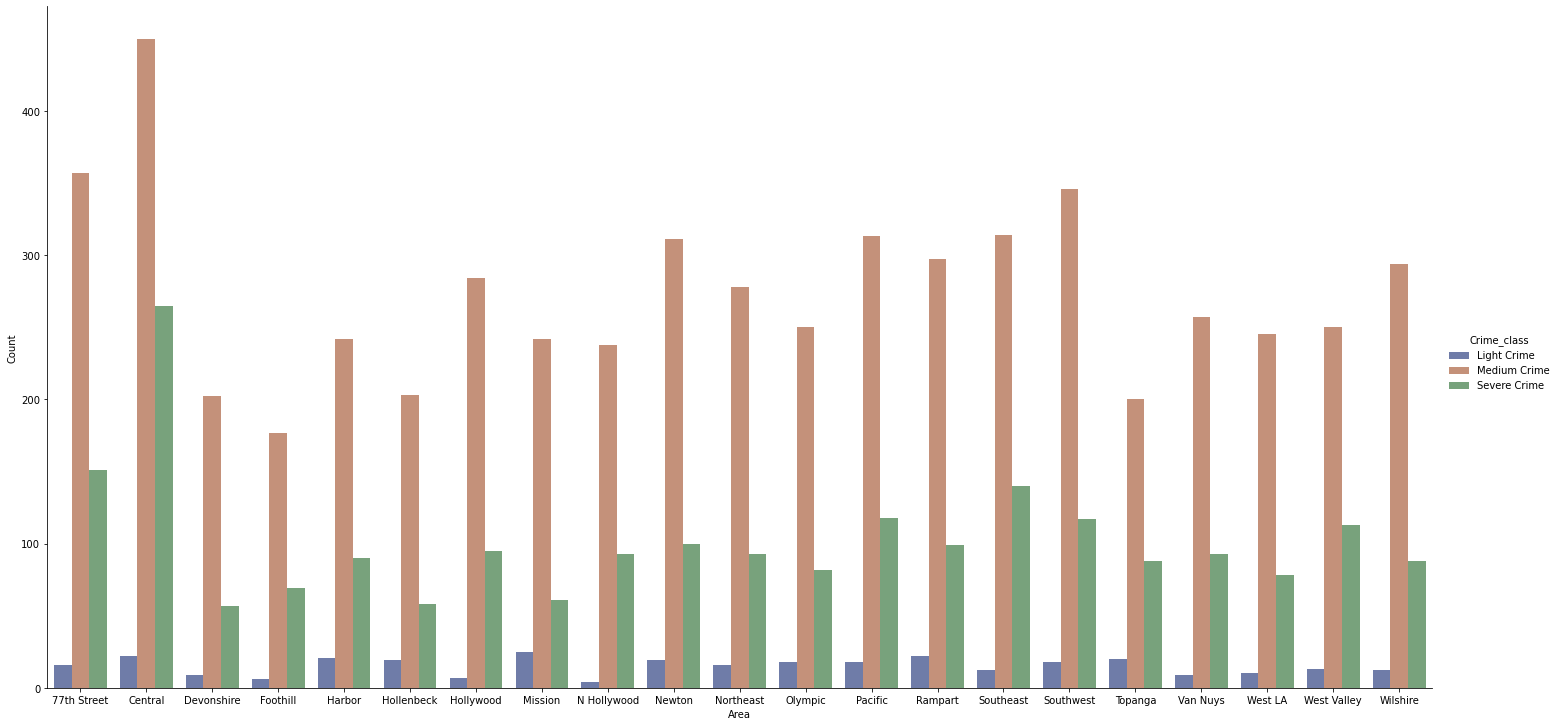

In [23]:
a = sns.catplot(
    data=plot_area, kind="bar",
    x="Area", y="Count", hue="Crime_class",
    ci="sd", palette="dark", alpha=.6, height=10,aspect = 20/10
)

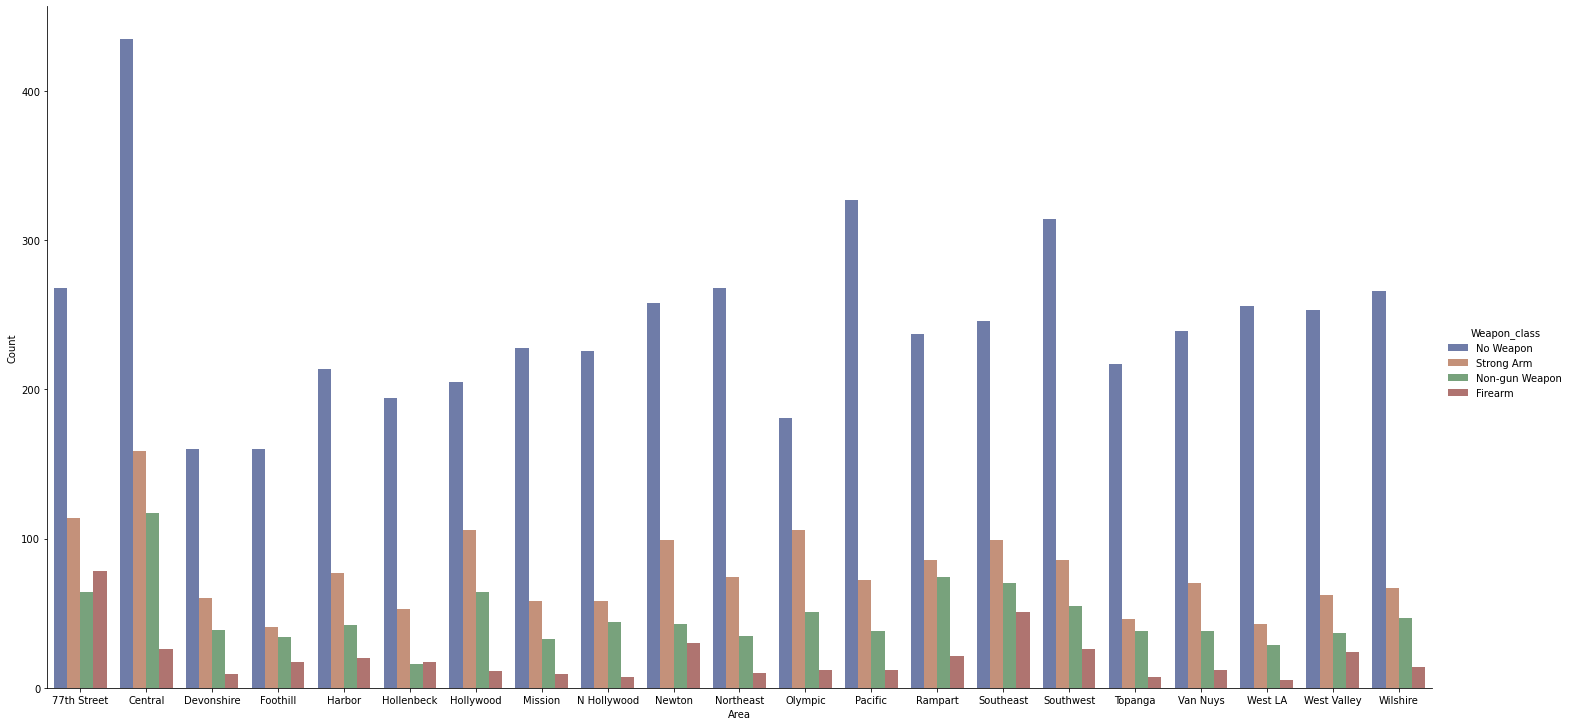

In [24]:
w = sns.catplot(
    data=plot_weapon, kind="bar",
    x="Area", y="Count", hue="Weapon_class",hue_order = ['No Weapon','Strong Arm','Non-gun Weapon','Firearm'],
    ci="sd", palette="dark", alpha=.6, height=10,aspect = 20/10
)

In [25]:
danger_score = la.groupby('Areas',as_index=False)['danger_score'].agg({'count':'count','sum':sum, 'mean':'mean'})

In [26]:
new_df = danger_score.merge(total_pop,left_on = 'Areas',right_on = 'Areas')
new_df['safety_index'] = 100*(1-new_df['sum']/new_df['total_pop']*1000)
new_df.to_csv('safety_index.csv')

In [27]:
new_df

,Areas,count,sum,mean,total_pop,safety_index
0,77th Street,524,42.13,0.080401,249592,83.120453
1,Central,737,49.42,0.067056,72832,32.145211
2,Devonshire,268,15.83,0.059067,292583,94.589569
3,Foothill,252,16.95,0.067262,320340,94.708747
4,Harbor,353,23.01,0.065184,294308,92.181660
5,Hollenbeck,280,16.18,0.057786,235615,93.132865
6,Hollywood,386,24.98,0.064715,57631,56.655272
7,Mission,328,17.35,0.052896,231596,92.508506
8,N Hollywood,335,19.90,0.059403,150931,86.815167
9,Newton,430,27.54,0.064047,107115,74.289315
